In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install Necessary Packages**

In [ ]:
!pip install igraph
!pip install leidenalg
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 5.4 MB/s eta 0:00:00


# **Import Necessary Libraries**

In [ ]:
import scanpy as sc
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(6, 4))

print(" Modern scRNA-seq analysis setup complete")
print(" Using: Scanpy + Polars + Matplotlib")


 Modern scRNA-seq analysis setup complete
 Using: Scanpy + Polars + Matplotlib


# **Load Dataset**

**Dataset:** [CD8+ T cells from 10x Genomics](https://www.10xgenomics.com/datasets/cd-8-plus-t-cells-of-healthy-donor-1-1-standard-3-0-2)

In [ ]:
# Load CD8+ T h5 data from 10x Genomics
adata_raw = sc.read_10x_h5('/content/drive/My Drive/CD8+ T Dataset/data.h5')

reading /content/drive/My Drive/CD8+ T Dataset/data.h5


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:06)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# **Dataset Overview**

In [ ]:
# Make gene names unique
adata_raw.var_names_make_unique()

# Display dataset using Pandas Dataframe
df = pd.DataFrame(adata_raw.var)
display(df)

gene_ids    feature_types  genome pattern read sequence
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38                      
FAM138A      ENSG00000237613  Gene Expression  GRCh38                      
OR4F5        ENSG00000186092  Gene Expression  GRCh38                      
AL627309.1   ENSG00000238009  Gene Expression  GRCh38                      
AL627309.3   ENSG00000239945  Gene Expression  GRCh38                      
...                      ...              ...     ...     ...  ...      ...
AC233755.2   ENSG00000277856  Gene Expression  GRCh38                      
AC233755.1   ENSG00000275063  Gene Expression  GRCh38                      
AC240274.1   ENSG00000271254  Gene Expression  GRCh38                      
AC213203.1   ENSG00000277475  Gene Expression  GRCh38                      
FAM231C      ENSG00000268674  Gene Expression  GRCh38                      

[33538 rows x 6 columns]

In [ ]:
# Create new columns to store gene information
adata_raw.var['ensemble_ids'] = adata_raw.var['gene_ids']
adata_raw.var['gene_symbols'] = adata_raw.var.index

print(f"\nDataset shape: {adata_raw.shape}")
print(f"Cells: {adata_raw.n_obs}, Genes: {adata_raw.n_vars}")
print(f"Gene names are unique: {adata_raw.var_names.is_unique}")

# Overview with polars
var_df = pl.from_pandas(adata_raw.var)
print(f"\n-------------------------------------------------------------------------------------------------")
display(var_df.head(5))
print(f"\n-------------------------------------------------------------------------------------------------")
print(f"\nFeature types: {var_df['feature_types'].unique().to_list()}")
print(f"First 10 genes: {adata_raw.var_names[:10].tolist()}")


Dataset shape: (55206, 33538)
Cells: 55206, Genes: 33538
Gene names are unique: True

-------------------------------------------------------------------------------------------------


shape: (5, 8)
┌───────────────┬───────────────┬────────┬─────────┬──────┬──────────┬──────────────┬──────────────┐
│ gene_ids      ┆ feature_types ┆ genome ┆ pattern ┆ read ┆ sequence ┆ ensemble_ids ┆ gene_symbols │
│ ---           ┆ ---           ┆ ---    ┆ ---     ┆ ---  ┆ ---      ┆ ---          ┆ ---          │
│ str           ┆ str           ┆ str    ┆ str     ┆ str  ┆ str      ┆ str          ┆ str          │
╞═══════════════╪═══════════════╪════════╪═════════╪══════╪══════════╪══════════════╪══════════════╡
│ ENSG000002434 ┆ Gene          ┆ GRCh38 ┆         ┆      ┆          ┆ ENSG00000243 ┆ MIR1302-2HG  │
│ 85            ┆ Expression    ┆        ┆         ┆      ┆          ┆ 485          ┆              │
│ ENSG000002376 ┆ Gene          ┆ GRCh38 ┆         ┆      ┆          ┆ ENSG00000237 ┆ FAM138A      │
│ 13            ┆ Expression    ┆        ┆         ┆      ┆          ┆ 613          ┆              │
│ ENSG000001860 ┆ Gene          ┆ GRCh38 ┆         ┆      ┆          ┆ ENSG00000186 ┆ OR4F5        │
│ 92            ┆ Expression    ┆        ┆         ┆      ┆          ┆ 092          ┆              │
│ ENSG000002380 ┆ Gene          ┆ GRCh38 ┆         ┆      ┆          ┆ ENSG00000238 ┆ AL627309.1   │
│ 09            ┆ Expression    ┆        ┆         ┆      ┆          ┆ 009          ┆              │
│ ENSG000002399 ┆ Gene          ┆ GRCh38 ┆         ┆      ┆          ┆ ENSG00000239 ┆ AL627309.3   │
│ 45            ┆ Expression    ┆        ┆         ┆      ┆          ┆ 945          ┆              │
└───────────────┴───────────────┴────────┴─────────┴──────┴──────────┴──────────────┴──────────────┘


-------------------------------------------------------------------------------------------------

Feature types: ['Gene Expression']
First 10 genes: ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3', 'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1']


# **Quality Control, QC Metrics**

Detect and filter out low quality cells and genes which could bias the results.

In [ ]:
# Calculate QC metrics
adata_qc = adata_raw.copy()

# Identify mitochondrial gene types
adata_qc.var['mt'] = adata_qc.var_names.str.startswith('MT-')

# Calculate per-cell QC metrics
sc.pp.calculate_qc_metrics(adata_qc, percent_top=None, log1p=False, inplace=True)

# Add mitochondrial gene percentages
adata_qc.obs['pct_counts_mt'] = adata_qc[:, adata_qc.var['mt']].X.sum(axis=1).A1 / adata_qc.obs['total_counts'] * 100

print(f"Found {adata_qc.var['mt'].sum()} mitochondrial genes")

# Create QC dataframe for analysis
qc_stats = pl.from_pandas(adata_qc.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']])

print("\nQC Statistics:")
print(qc_stats.describe())

Found 13 mitochondrial genes

QC Statistics:
shape: (9, 4)
┌────────────┬──────────────┬───────────────────┬───────────────┐
│ statistic  ┆ total_counts ┆ n_genes_by_counts ┆ pct_counts_mt │
│ ---        ┆ ---          ┆ ---               ┆ ---           │
│ str        ┆ f64          ┆ f64               ┆ f64           │
╞════════════╪══════════════╪═══════════════════╪═══════════════╡
│ count      ┆ 55206.0      ┆ 55206.0           ┆ 55206.0       │
│ null_count ┆ 0.0          ┆ 0.0               ┆ 0.0           │
│ mean       ┆ 4062.812012  ┆ 1362.929808       ┆ 10.206057     │
│ std        ┆ 2481.679199  ┆ 550.995981        ┆ 8.005322      │
│ min        ┆ 763.0        ┆ 68.0              ┆ 0.0           │
│ 25%        ┆ 1931.0       ┆ 910.0             ┆ 5.048163      │
│ 50%        ┆ 4003.0       ┆ 1414.0            ┆ 6.646111      │
│ 75%        ┆ 5354.0       ┆ 1690.0            ┆ 12.970354     │
│ max        ┆ 52819.0      ┆ 6078.0            ┆ 94.056076     │
└────────────┴───

# **Quality Control, QC Visualization**

QC plots for 55,206 cells



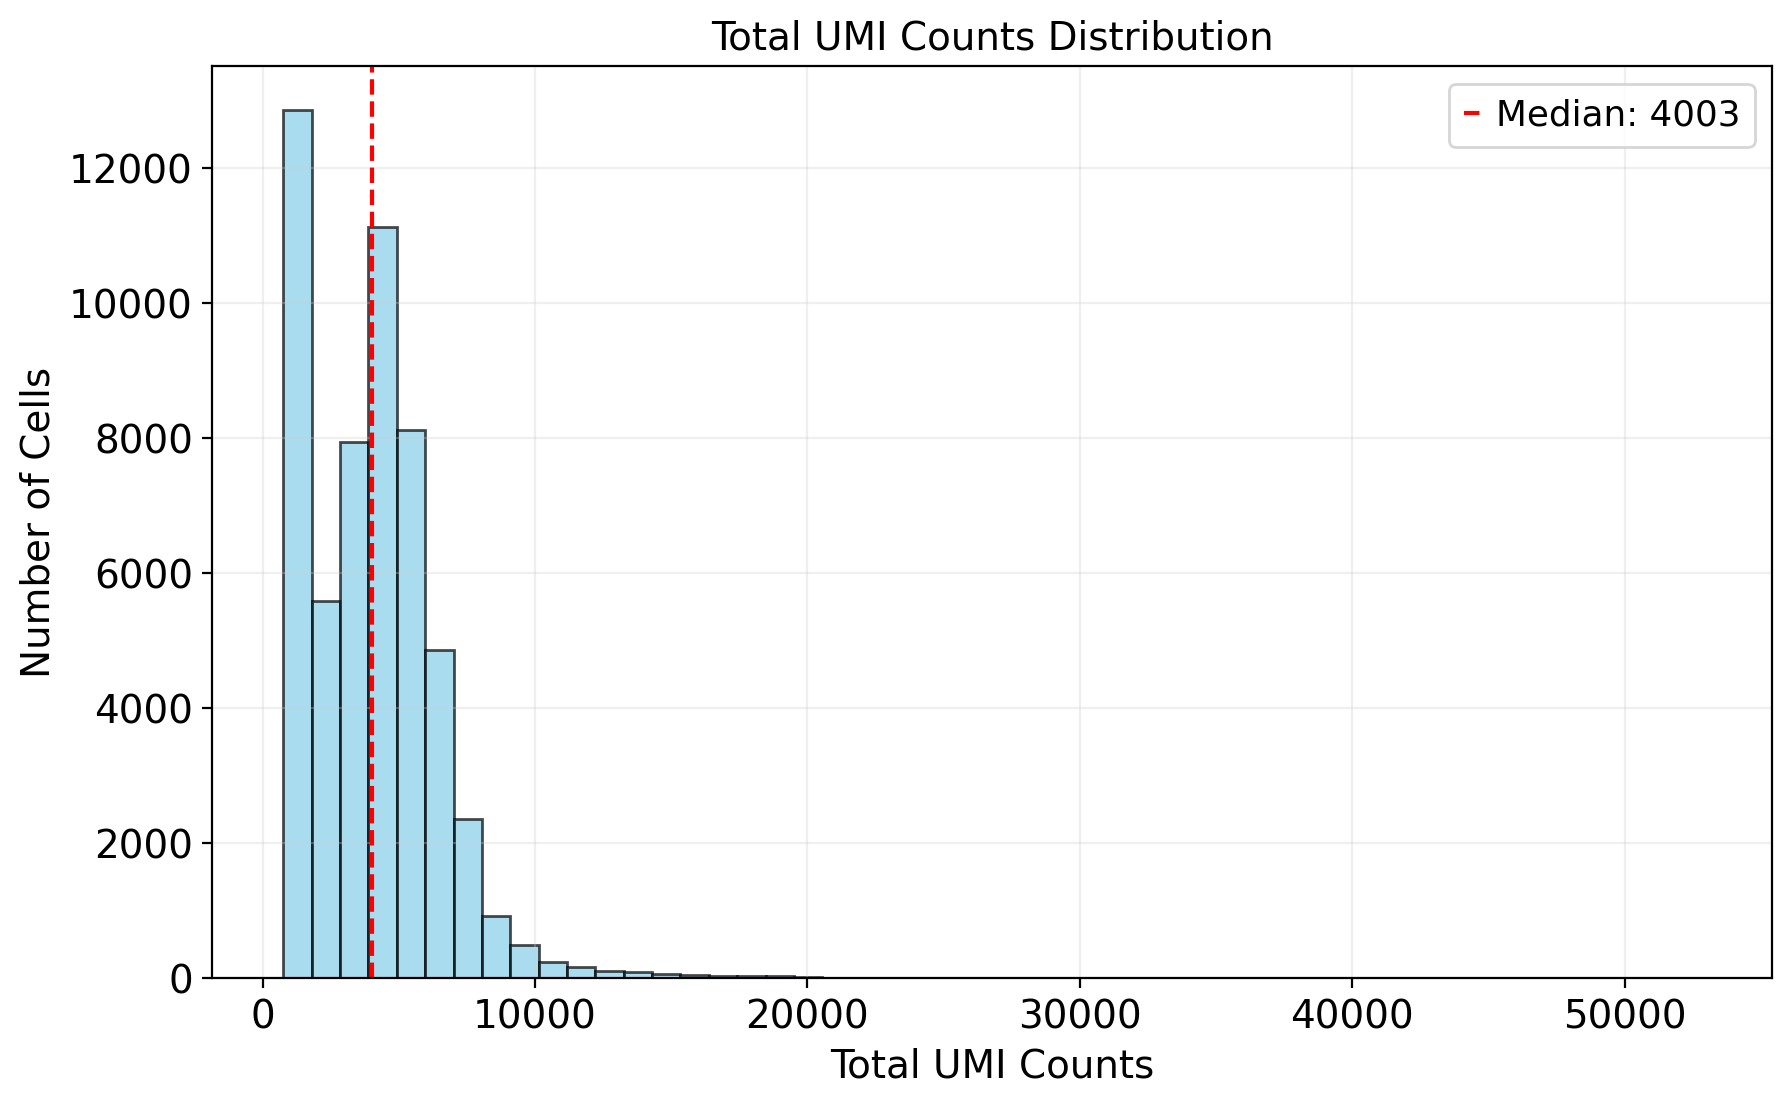

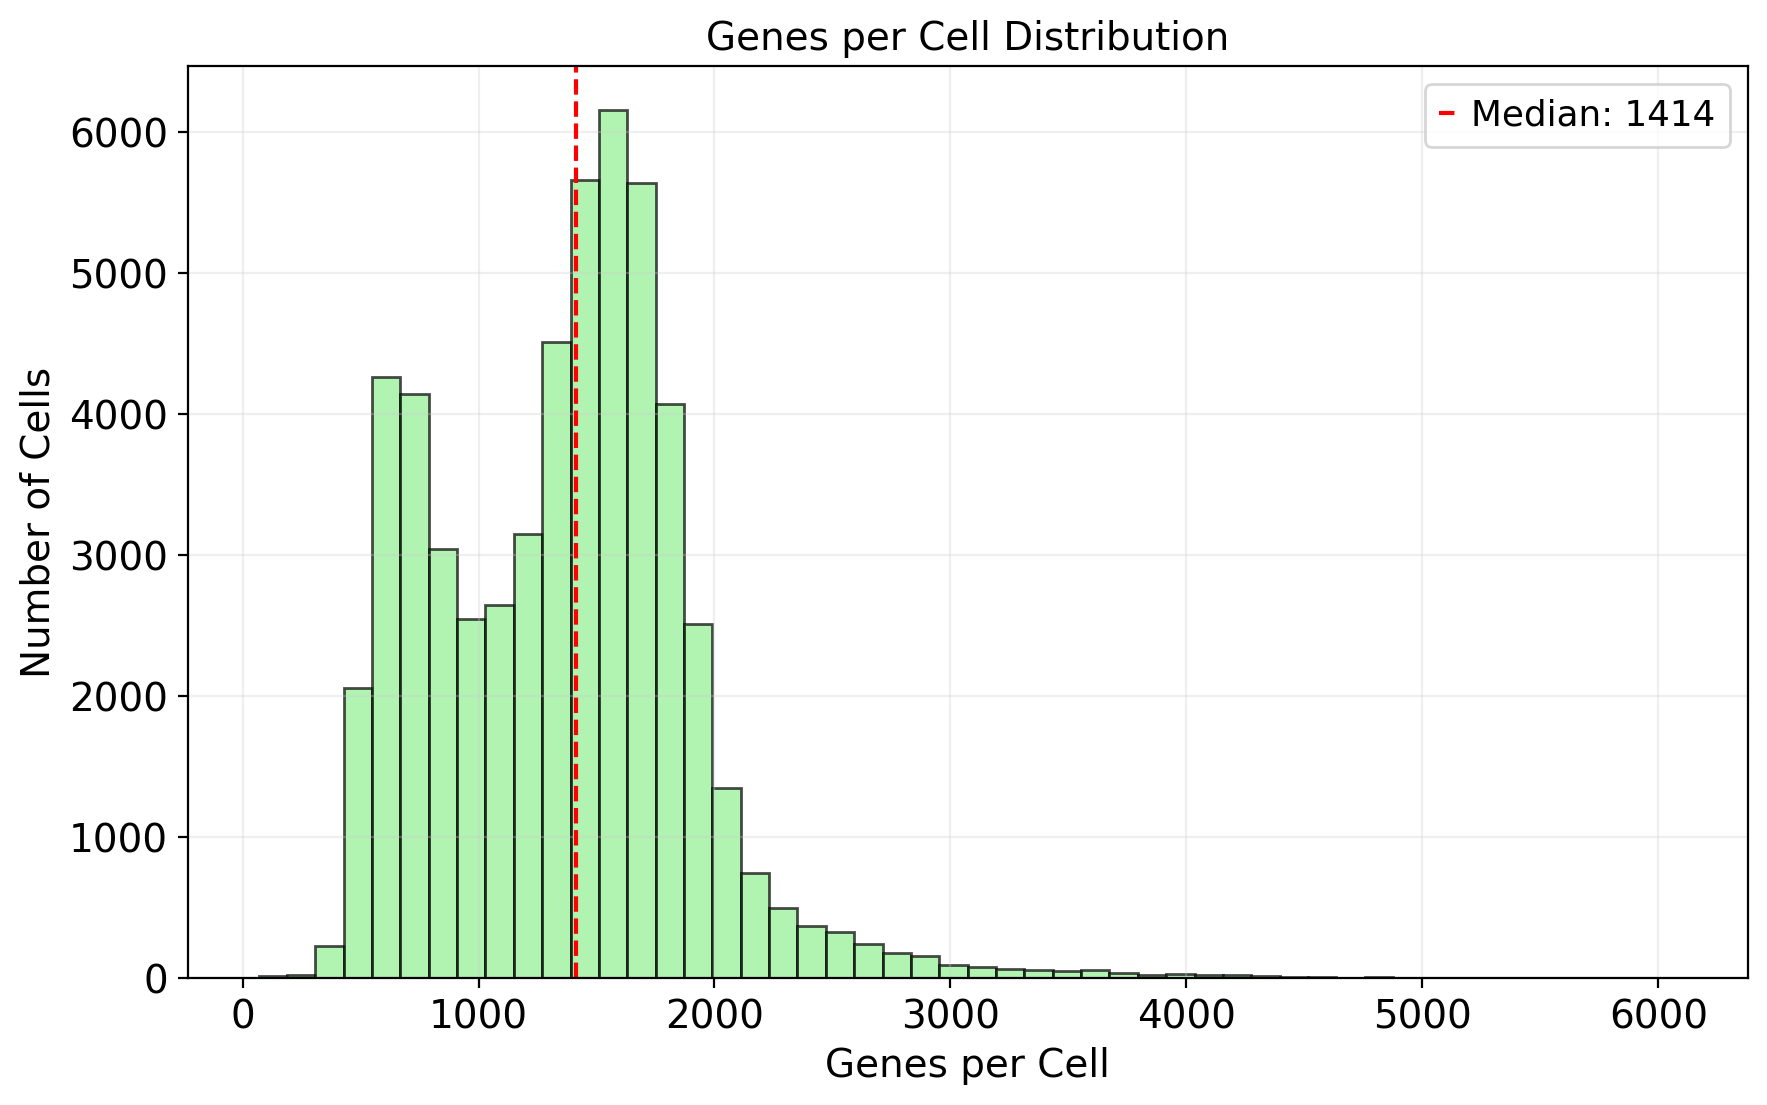

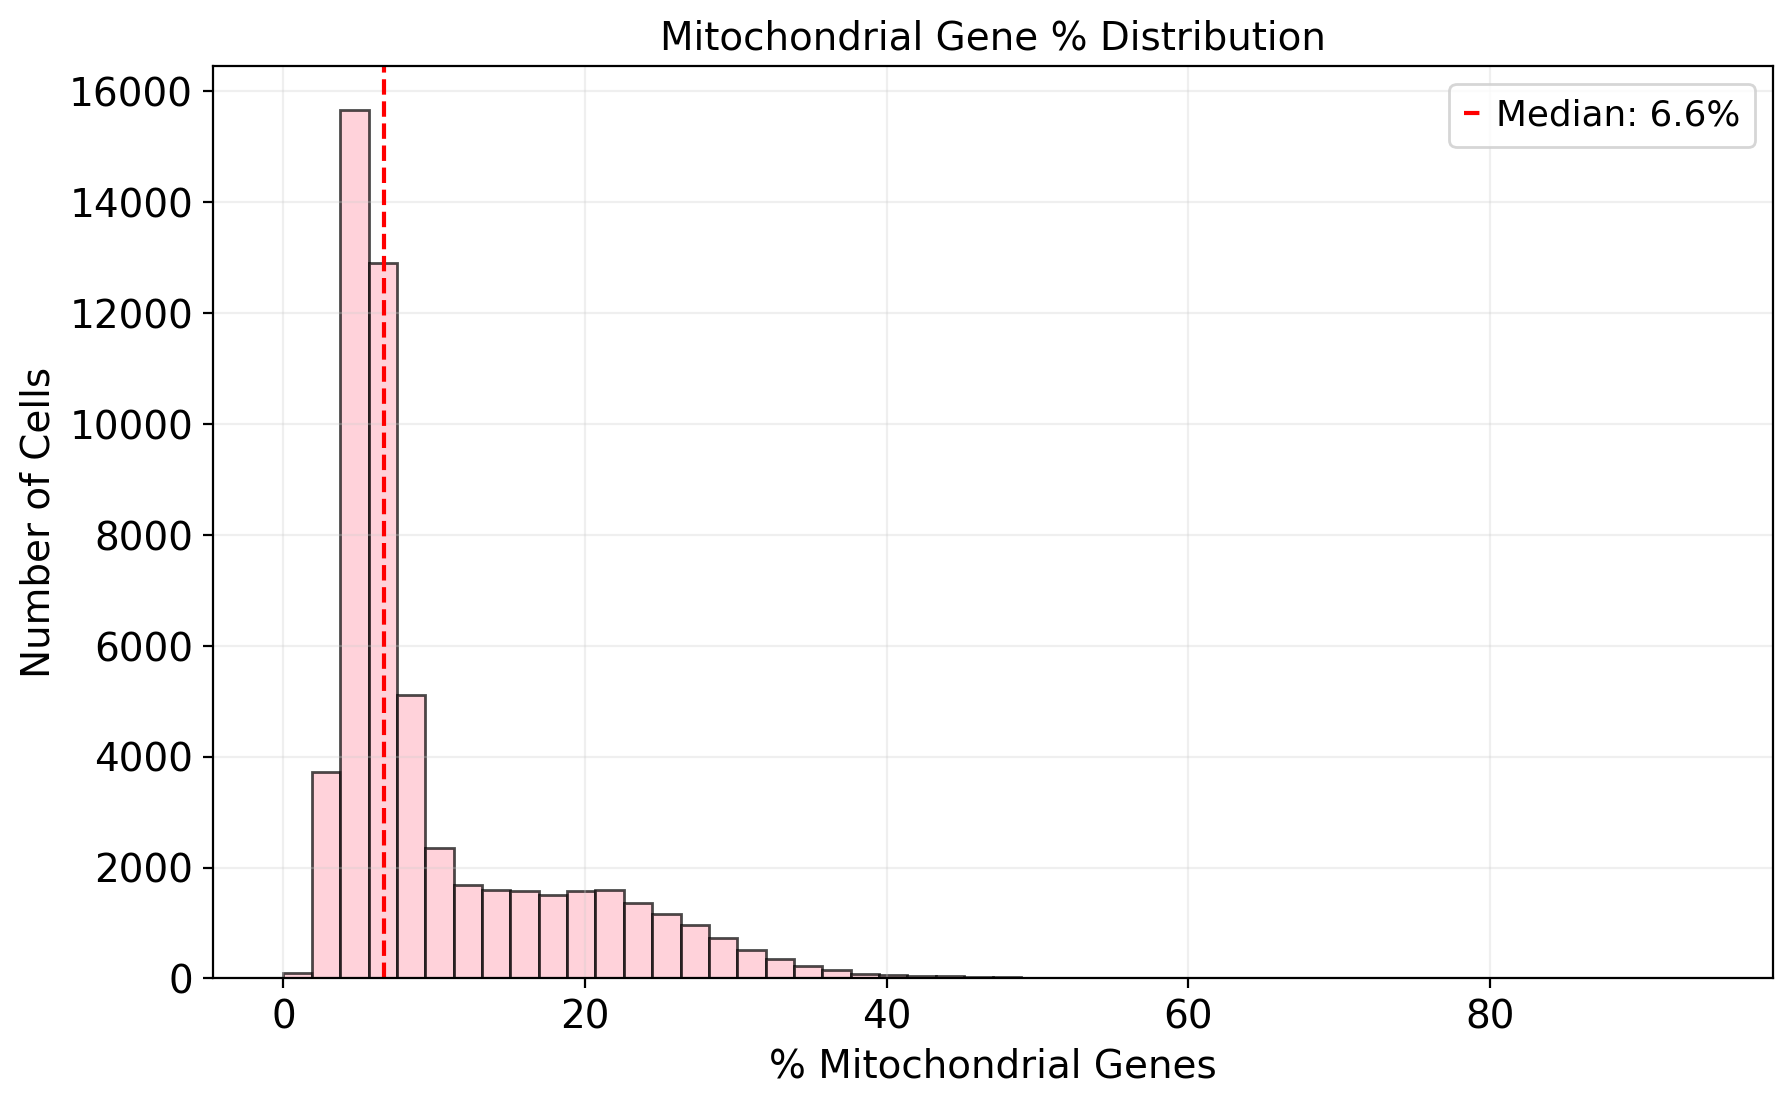

In [ ]:
plot_data = qc_stats.to_pandas()

print(f"QC plots for {len(plot_data):,} cells\n")

# Plot 1: Total Unique Molecular Identifiers, UMI counts
plt.figure(figsize=(10, 6))
plt.hist(plot_data['total_counts'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
plt.xlabel('Total UMI Counts')
plt.ylabel('Number of Cells')
plt.title('Total UMI Counts Distribution')
plt.grid(True, alpha=0.3)
plt.axvline(plot_data['total_counts'].median(), color='red', linestyle='--', label=f'Median: {plot_data["total_counts"].median():.0f}')
plt.legend()
plt.show()

# Plot 2: Genes per cell
plt.figure(figsize=(10, 6))
plt.hist(plot_data['n_genes_by_counts'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
plt.xlabel('Genes per Cell')
plt.ylabel('Number of Cells')
plt.title('Genes per Cell Distribution')
plt.grid(True, alpha=0.3)
plt.axvline(plot_data['n_genes_by_counts'].median(), color='red', linestyle='--', label=f'Median: {plot_data["n_genes_by_counts"].median():.0f}')
plt.legend()
plt.show()

# Plot 3: Mitochondrial percentage
plt.figure(figsize=(10, 6))
plt.hist(plot_data['pct_counts_mt'], bins=50, color='pink', alpha=0.7, edgecolor='black')
plt.xlabel('% Mitochondrial Genes')
plt.ylabel('Number of Cells')
plt.title('Mitochondrial Gene % Distribution')
plt.grid(True, alpha=0.3)
plt.axvline(plot_data['pct_counts_mt'].median(), color='red', linestyle='--', label=f'Median: {plot_data["pct_counts_mt"].median():.1f}%')
plt.legend()
plt.show()

# **Quality Control, QC Filtering**

This filtering step is done to ensure low-quality cells and genes are not taken into consideration in our downstream analysis.

Filtering out empty droplets, doublets, cells which have high mitochondrial percentage (indicates stressed or dying cells) and genes expressed in less than 0.01% of the cells (not informative) results in reliable data for downstream analysis.


In [ ]:
# Calculate filtering thresholds based on QC Statistics using quantiles
filtering_thresholds = qc_stats.select([
    pl.col('total_counts').quantile(0.02).alias('min_counts_2pct'),
    pl.col('total_counts').quantile(0.98).alias('max_counts_98pct'),
    pl.col('n_genes_by_counts').quantile(0.02).alias('min_genes_2pct'),
    pl.col('n_genes_by_counts').quantile(0.98).alias('max_genes_98pct'),
    pl.col('pct_counts_mt').quantile(0.95).alias('max_mt_95pct'),
    pl.col('pct_counts_mt').quantile(0.98).alias('max_mt_98pct')
])

print("Suggested filtering thresholds:")
print(filtering_thresholds)

# Create a new dataframe for filtered data
adata_filtered = adata_qc.copy()

print(f"Cells before filtering: {adata_filtered.n_obs}")
print(f"Genes before filtering: {adata_filtered.n_vars}")

# Get thresholds
thresh = filtering_thresholds.to_dicts()[0]
min_genes = max(200, int(thresh['min_genes_2pct']))
max_genes = min(6000, int(thresh['max_genes_98pct']))
max_mt = min(25, thresh['max_mt_95pct'])

print(f"Using thresholds: min_genes={min_genes}, max_genes={max_genes}, max_mt={max_mt:.1f}%")

# Apply cell filters
sc.pp.filter_cells(adata_filtered, min_genes=min_genes)
adata_filtered = adata_filtered[adata_filtered.obs.n_genes_by_counts < max_genes, :]
adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_mt < max_mt, :]

# Apply gene filters
min_cells = max(3, int(adata_filtered.n_obs * 0.0001))  # Genes in at least 0.01% of cells
sc.pp.filter_genes(adata_filtered, min_cells=min_cells)

print(f"Cells after filtering: {adata_filtered.n_obs}")
print(f"Genes after filtering: {adata_filtered.n_vars}")
print(f"Removed {adata_raw.n_obs - adata_filtered.n_obs:,} cells and {adata_raw.n_vars - adata_filtered.n_vars:,} genes")


Suggested filtering thresholds:
shape: (1, 6)
┌─────────────────┬────────────────┬────────────────┬────────────────┬──────────────┬──────────────┐
│ min_counts_2pct ┆ max_counts_98p ┆ min_genes_2pct ┆ max_genes_98pc ┆ max_mt_95pct ┆ max_mt_98pct │
│ ---             ┆ ct             ┆ ---            ┆ t              ┆ ---          ┆ ---          │
│ f32             ┆ ---            ┆ f64            ┆ ---            ┆ f32          ┆ f32          │
│                 ┆ f32            ┆                ┆ f64            ┆              ┆              │
╞═════════════════╪════════════════╪════════════════╪════════════════╪══════════════╪══════════════╡
│ 989.0           ┆ 9643.0         ┆ 500.0          ┆ 2642.0         ┆ 27.334467    ┆ 31.894934    │
└─────────────────┴────────────────┴────────────────┴────────────────┴──────────────┴──────────────┘
Cells before filtering: 55206
Genes before filtering: 33538
Using thresholds: min_genes=500, max_genes=2642, max_mt=25.0%
filtered out 1099 cells 

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Cells after filtering: 49661
Genes after filtering: 18860
Removed 5,545 cells and 14,678 genes


# **Normalization & Highly Variable Gene Detection**

**Normalization:** Removes technical noise and makes the total number of counts per cell comparable across different cells.

Scale the total number of counts by 10,000 and then apply log transformation to stabilize the variance and reduce the impact of highly expressed genes.

**Highly Variable Gene Identification:**
Identifying genes with biological signals which are distinct from technical noise or housekeeping genes and show a significant amount of cell-to-cell variability. These highly variable genes reflect geniuine biological differences between cells.


normalizing counts per cell
    finished (0:00:04)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

Found 3000 highly variable genes



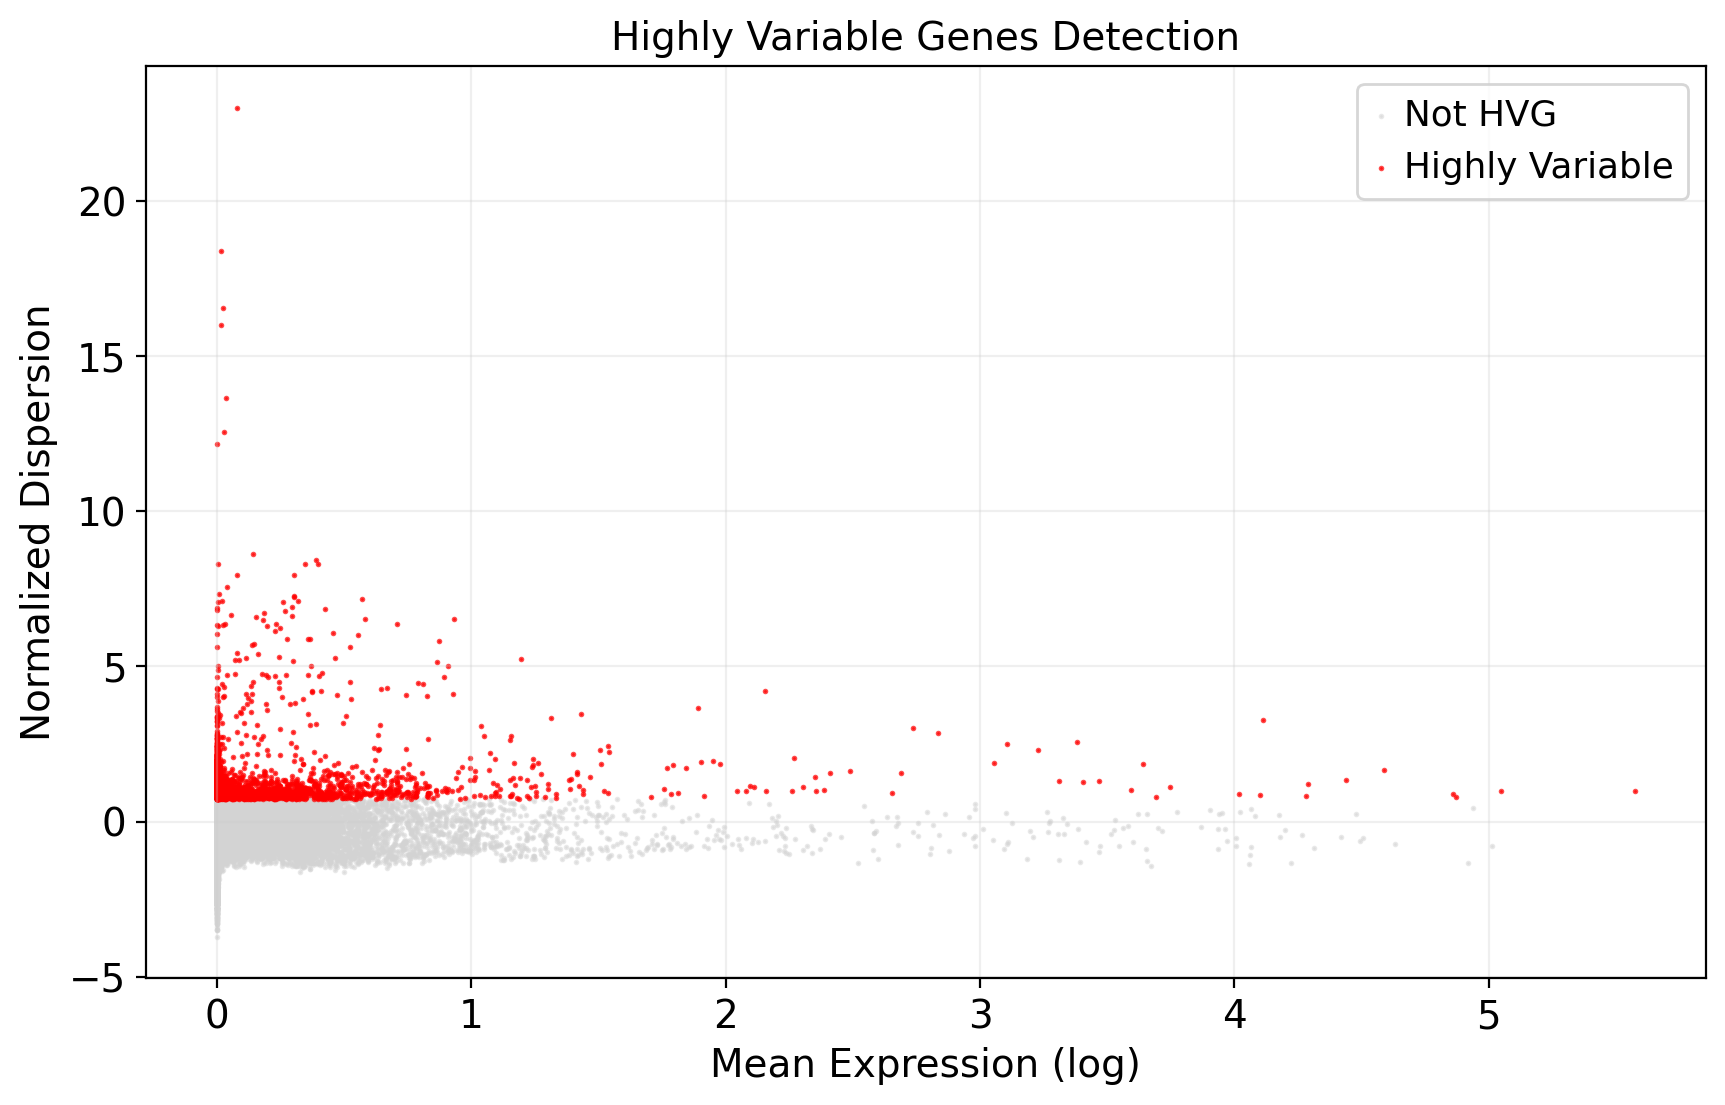

Dataset for downstream analysis: (49661, 3000)


In [ ]:
# Preprocessing pipeline
adata_processed = adata_filtered.copy()

# Save raw data
adata_processed.raw = adata_processed

# Normalization and log transformation
sc.pp.normalize_total(adata_processed, target_sum=1e4)
sc.pp.log1p(adata_processed)

# Find highly variable genes
sc.pp.highly_variable_genes(adata_processed, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=3000)

print(f"\nFound {adata_processed.var.highly_variable.sum()} highly variable genes\n")

# Visualize highly variable genes
hvg_data = adata_processed.var.copy()

plt.figure(figsize=(10, 6))
plt.scatter(hvg_data.loc[~hvg_data.highly_variable, 'means'],
            hvg_data.loc[~hvg_data.highly_variable, 'dispersions_norm'],
            c='lightgray', s=1, alpha=0.5, label='Not HVG')
plt.scatter(hvg_data.loc[hvg_data.highly_variable, 'means'],
            hvg_data.loc[hvg_data.highly_variable, 'dispersions_norm'],
            c='red', s=1, alpha=0.7, label='Highly Variable')
plt.xlabel('Mean Expression (log)')
plt.ylabel('Normalized Dispersion')
plt.title('Highly Variable Genes Detection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Keep only highly variable genes for downstream analysis
adata_hvg = adata_processed[:, adata_processed.var.highly_variable].copy()
print(f"Dataset for downstream analysis: {adata_hvg.shape}")

# **Dimensionality Reduction using PCA**




/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=50
    finished (0:01:42)


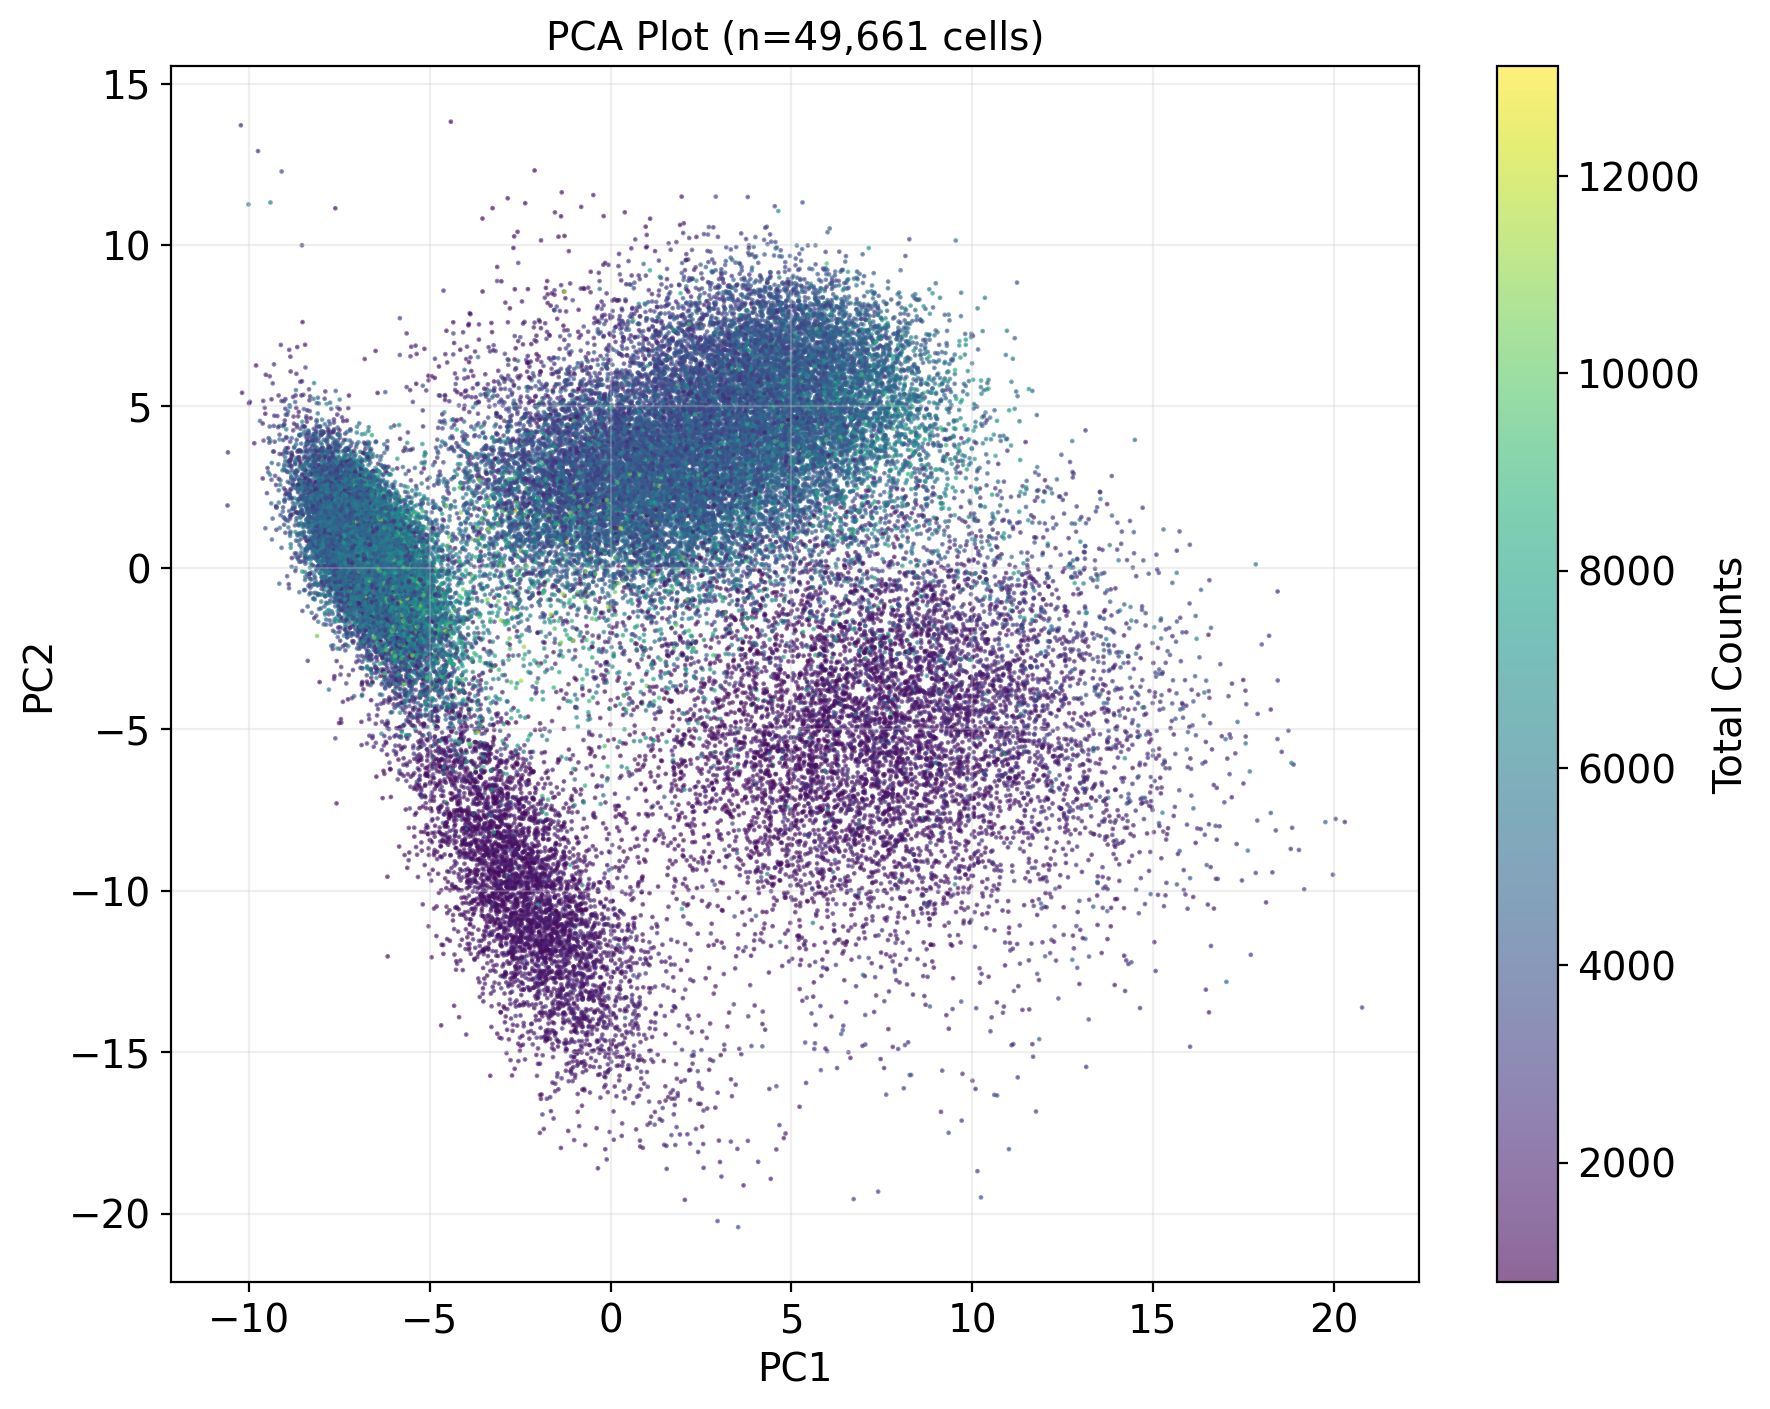

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:46)
 Dimensionality reduction complete
PCA: (49661, 50)
UMAP: (49661, 2)


In [ ]:
# Dimensionality reduction pipeline
adata_dimred = adata_hvg.copy()

# Scale data
sc.pp.scale(adata_dimred, max_value=10)

# Principal component analysis
sc.tl.pca(adata_dimred, svd_solver='arpack')

# Visualize PCA
pca_coords = adata_dimred.obsm['X_pca']
total_counts = adata_dimred.obs['total_counts']

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_coords[:, 0], pca_coords[:, 1],
                      c=total_counts, s=0.5, alpha=0.6, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA Plot (n={len(pca_coords):,} cells)')
plt.colorbar(scatter, label='Total Counts')
plt.grid(True, alpha=0.3)
plt.show()

# Compute neighborhood graph
sc.pp.neighbors(adata_dimred, n_neighbors=10, n_pcs=40)

# UMAP embedding
sc.tl.umap(adata_dimred)

print(" Dimensionality reduction complete")
print(f"PCA: {adata_dimred.obsm['X_pca'].shape}")
print(f"UMAP: {adata_dimred.obsm['X_umap'].shape}")

# **Clustering using Leiden Algorithm**

Identify groups of cells which are similar to each other using clustering.


In [ ]:
# Perform Leiden clustering
adata_clustered = adata_dimred.copy()

# Try different resolutions
resolutions = [0.3, 0.5, 0.8]
for res in resolutions:
    sc.tl.leiden(adata_clustered, resolution=res, key_added=f'leiden_res_{res}')

# Use resolution 0.5 as default
sc.tl.leiden(adata_clustered, resolution=0.5)

# Calculate cluster statistics
cluster_stats = []
for cluster in adata_clustered.obs['leiden'].cat.categories:
    cluster_mask = adata_clustered.obs['leiden'] == cluster
    cluster_cells = adata_clustered[cluster_mask]

    stats = {
        'cluster': cluster,
        'n_cells': cluster_mask.sum(),
        'mean_counts': cluster_cells.obs['total_counts'].mean(),
        'mean_genes': cluster_cells.obs['n_genes_by_counts'].mean(),
        'mean_mt_pct': cluster_cells.obs['pct_counts_mt'].mean()
    }
    cluster_stats.append(stats)

cluster_df = pl.DataFrame(cluster_stats)
print("Cluster Statistics:")
print(cluster_df)

print(f" Identified {len(adata_clustered.obs['leiden'].cat.categories)} clusters")

running Leiden clustering


/tmp/ipython-input-2244892557.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_clustered, resolution=res, key_added=f'leiden_res_{res}')


    finished: found 16 clusters and added
    'leiden_res_0.3', the cluster labels (adata.obs, categorical) (0:00:50)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden_res_0.5', the cluster labels (adata.obs, categorical) (0:00:34)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden_res_0.8', the cluster labels (adata.obs, categorical) (0:01:28)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:34)
Cluster Statistics:
shape: (23, 5)
┌─────────┬─────────┬─────────────┬─────────────┬─────────────┐
│ cluster ┆ n_cells ┆ mean_counts ┆ mean_genes  ┆ mean_mt_pct │
│ ---     ┆ ---     ┆ ---         ┆ ---         ┆ ---         │
│ str     ┆ i64     ┆ f64         ┆ f64         ┆ f64         │
╞═════════╪═════════╪═════════════╪═════════════╪═════════════╡
│ 0       ┆ 15483   ┆ 5446.017578 ┆ 1520.884841 ┆ 6.399298    │
│ 1       ┆ 6260    ┆ 4319.52002  ┆ 156

# **Cluster Visualization using UMAP**

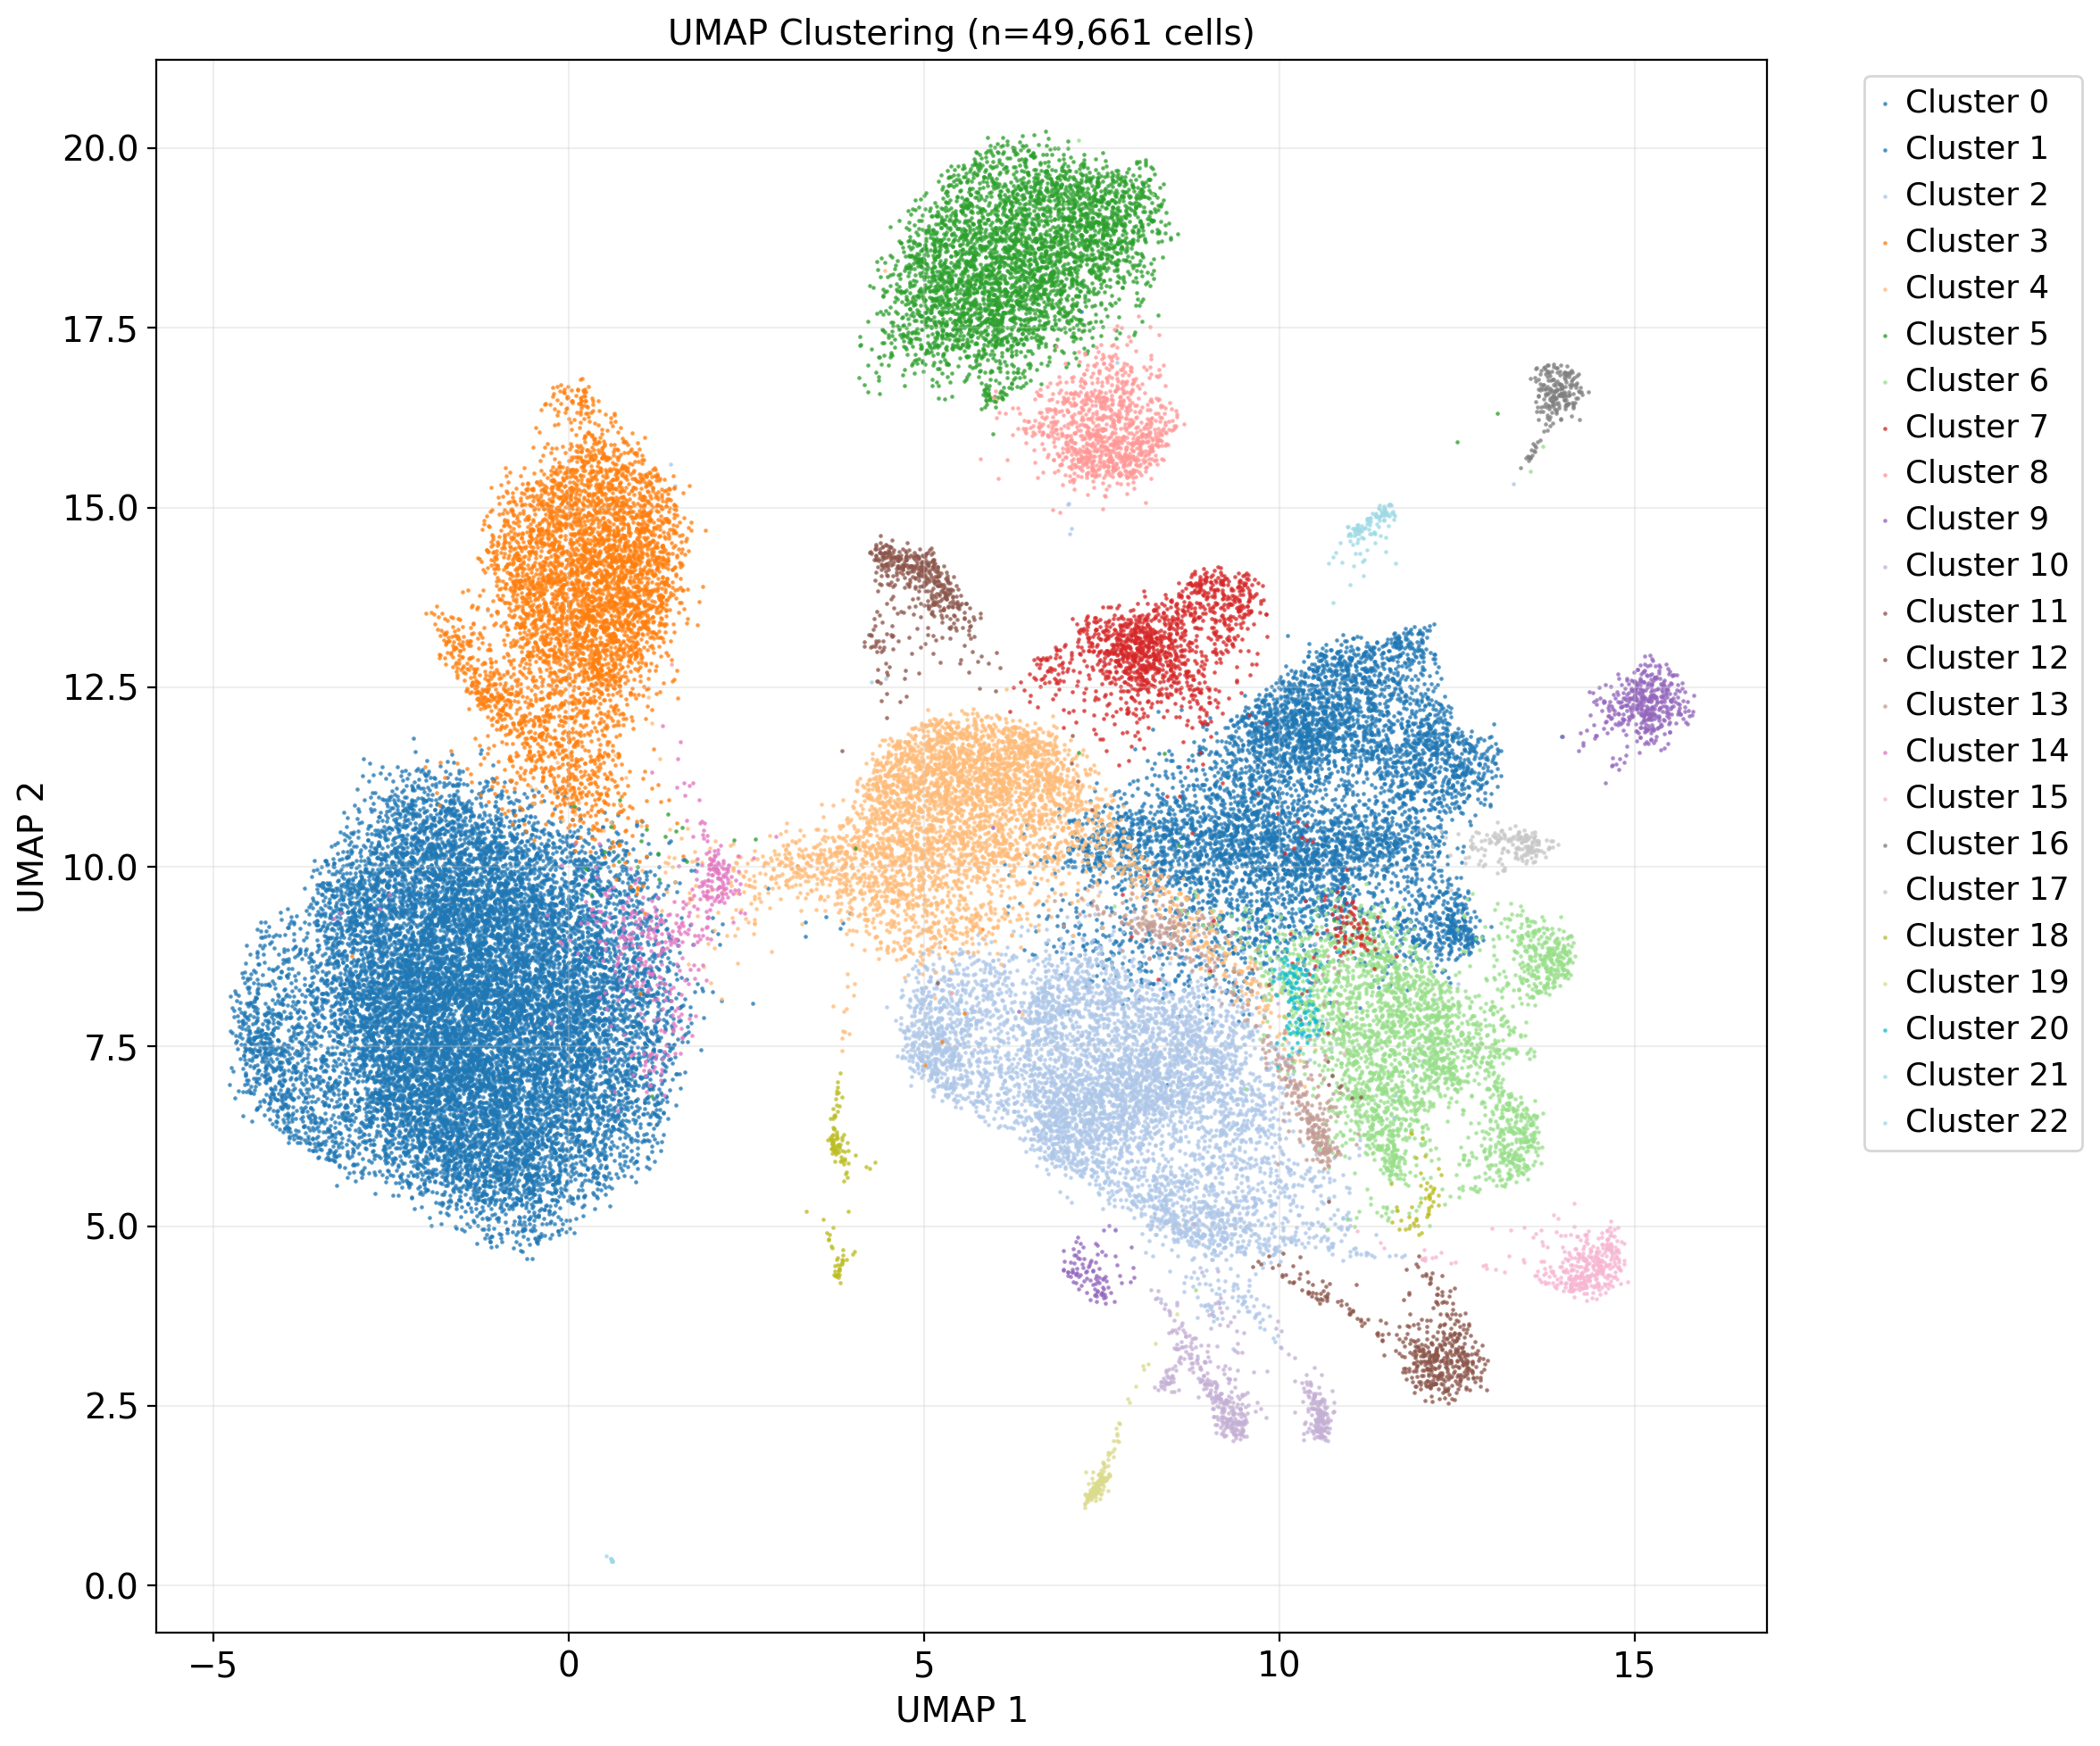

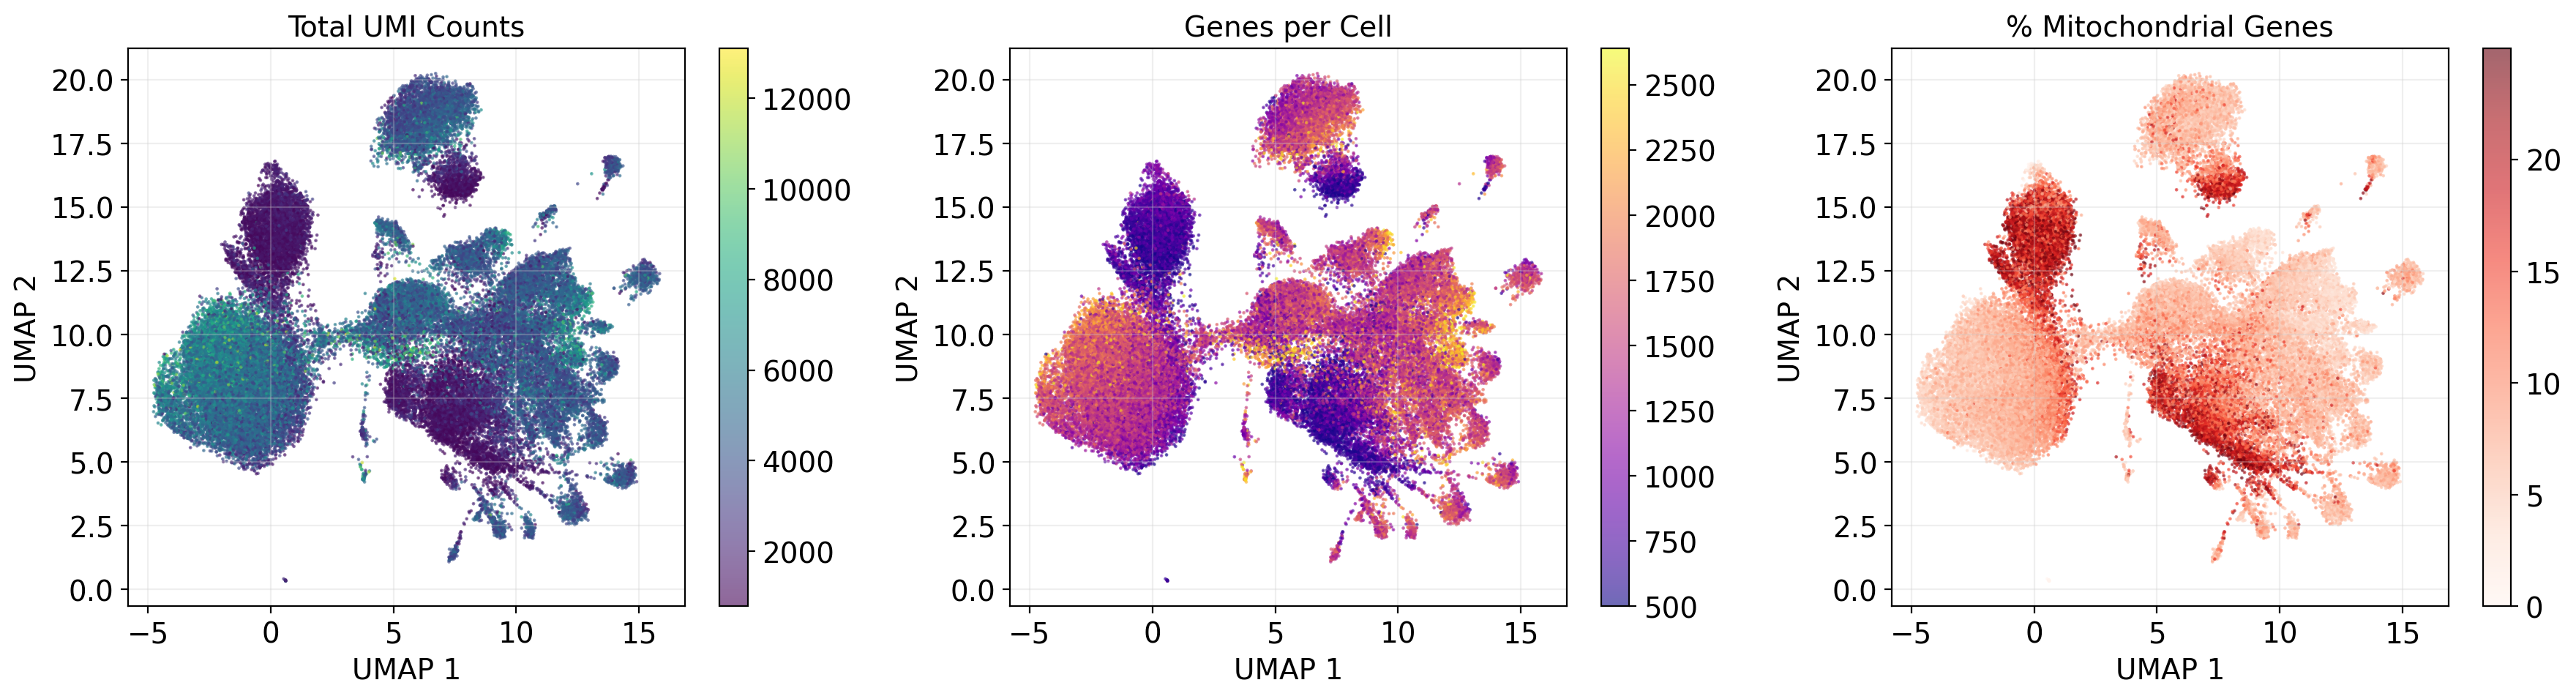

In [ ]:
# Create comprehensive UMAP visualizations
umap_coordinates = adata_clustered.obsm['X_umap']
cluster_labels = adata_clustered.obs['leiden']
cell_total_counts = adata_clustered.obs['total_counts']
cell_n_genes = adata_clustered.obs['n_genes_by_counts']
cell_pct_mt = adata_clustered.obs['pct_counts_mt']

# Cluster plot
plt.figure(figsize=(12, 10))
unique_cluster_ids = cluster_labels.cat.categories
cluster_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_cluster_ids)))

for i, cluster_id in enumerate(unique_cluster_ids):
    cluster_mask_umap = cluster_labels == cluster_id
    plt.scatter(umap_coordinates[cluster_mask_umap, 0], umap_coordinates[cluster_mask_umap, 1],
                c=[cluster_colors[i]], s=0.5, alpha=0.7, label=f'Cluster {cluster_id}')

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'UMAP Clustering (n={len(umap_coordinates):,} cells)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# QC metrics overlays
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total counts
scatter_counts = axes[0].scatter(umap_coordinates[:, 0], umap_coordinates[:, 1],
                                c=cell_total_counts, s=0.5, alpha=0.6, cmap='viridis')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].set_title('Total UMI Counts')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter_counts, ax=axes[0])

# Number of genes
scatter_genes = axes[1].scatter(umap_coordinates[:, 0], umap_coordinates[:, 1],
                                c=cell_n_genes, s=0.5, alpha=0.6, cmap='plasma')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('Genes per Cell')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter_genes, ax=axes[1])

# Mitochondrial percentage
scatter_mito = axes[2].scatter(umap_coordinates[:, 0], umap_coordinates[:, 1],
                              c=cell_pct_mt, s=0.5, alpha=0.6, cmap='Reds')
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')
axes[2].set_title('% Mitochondrial Genes')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter_mito, ax=axes[2])

plt.tight_layout()
plt.show()

# **Marker Gene Identification & Visualization**

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:51)


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

Available CD8+ T cell markers: ['GZMB', 'PRF1', 'IFNG', 'TNF', 'CCR7', 'IL7R']


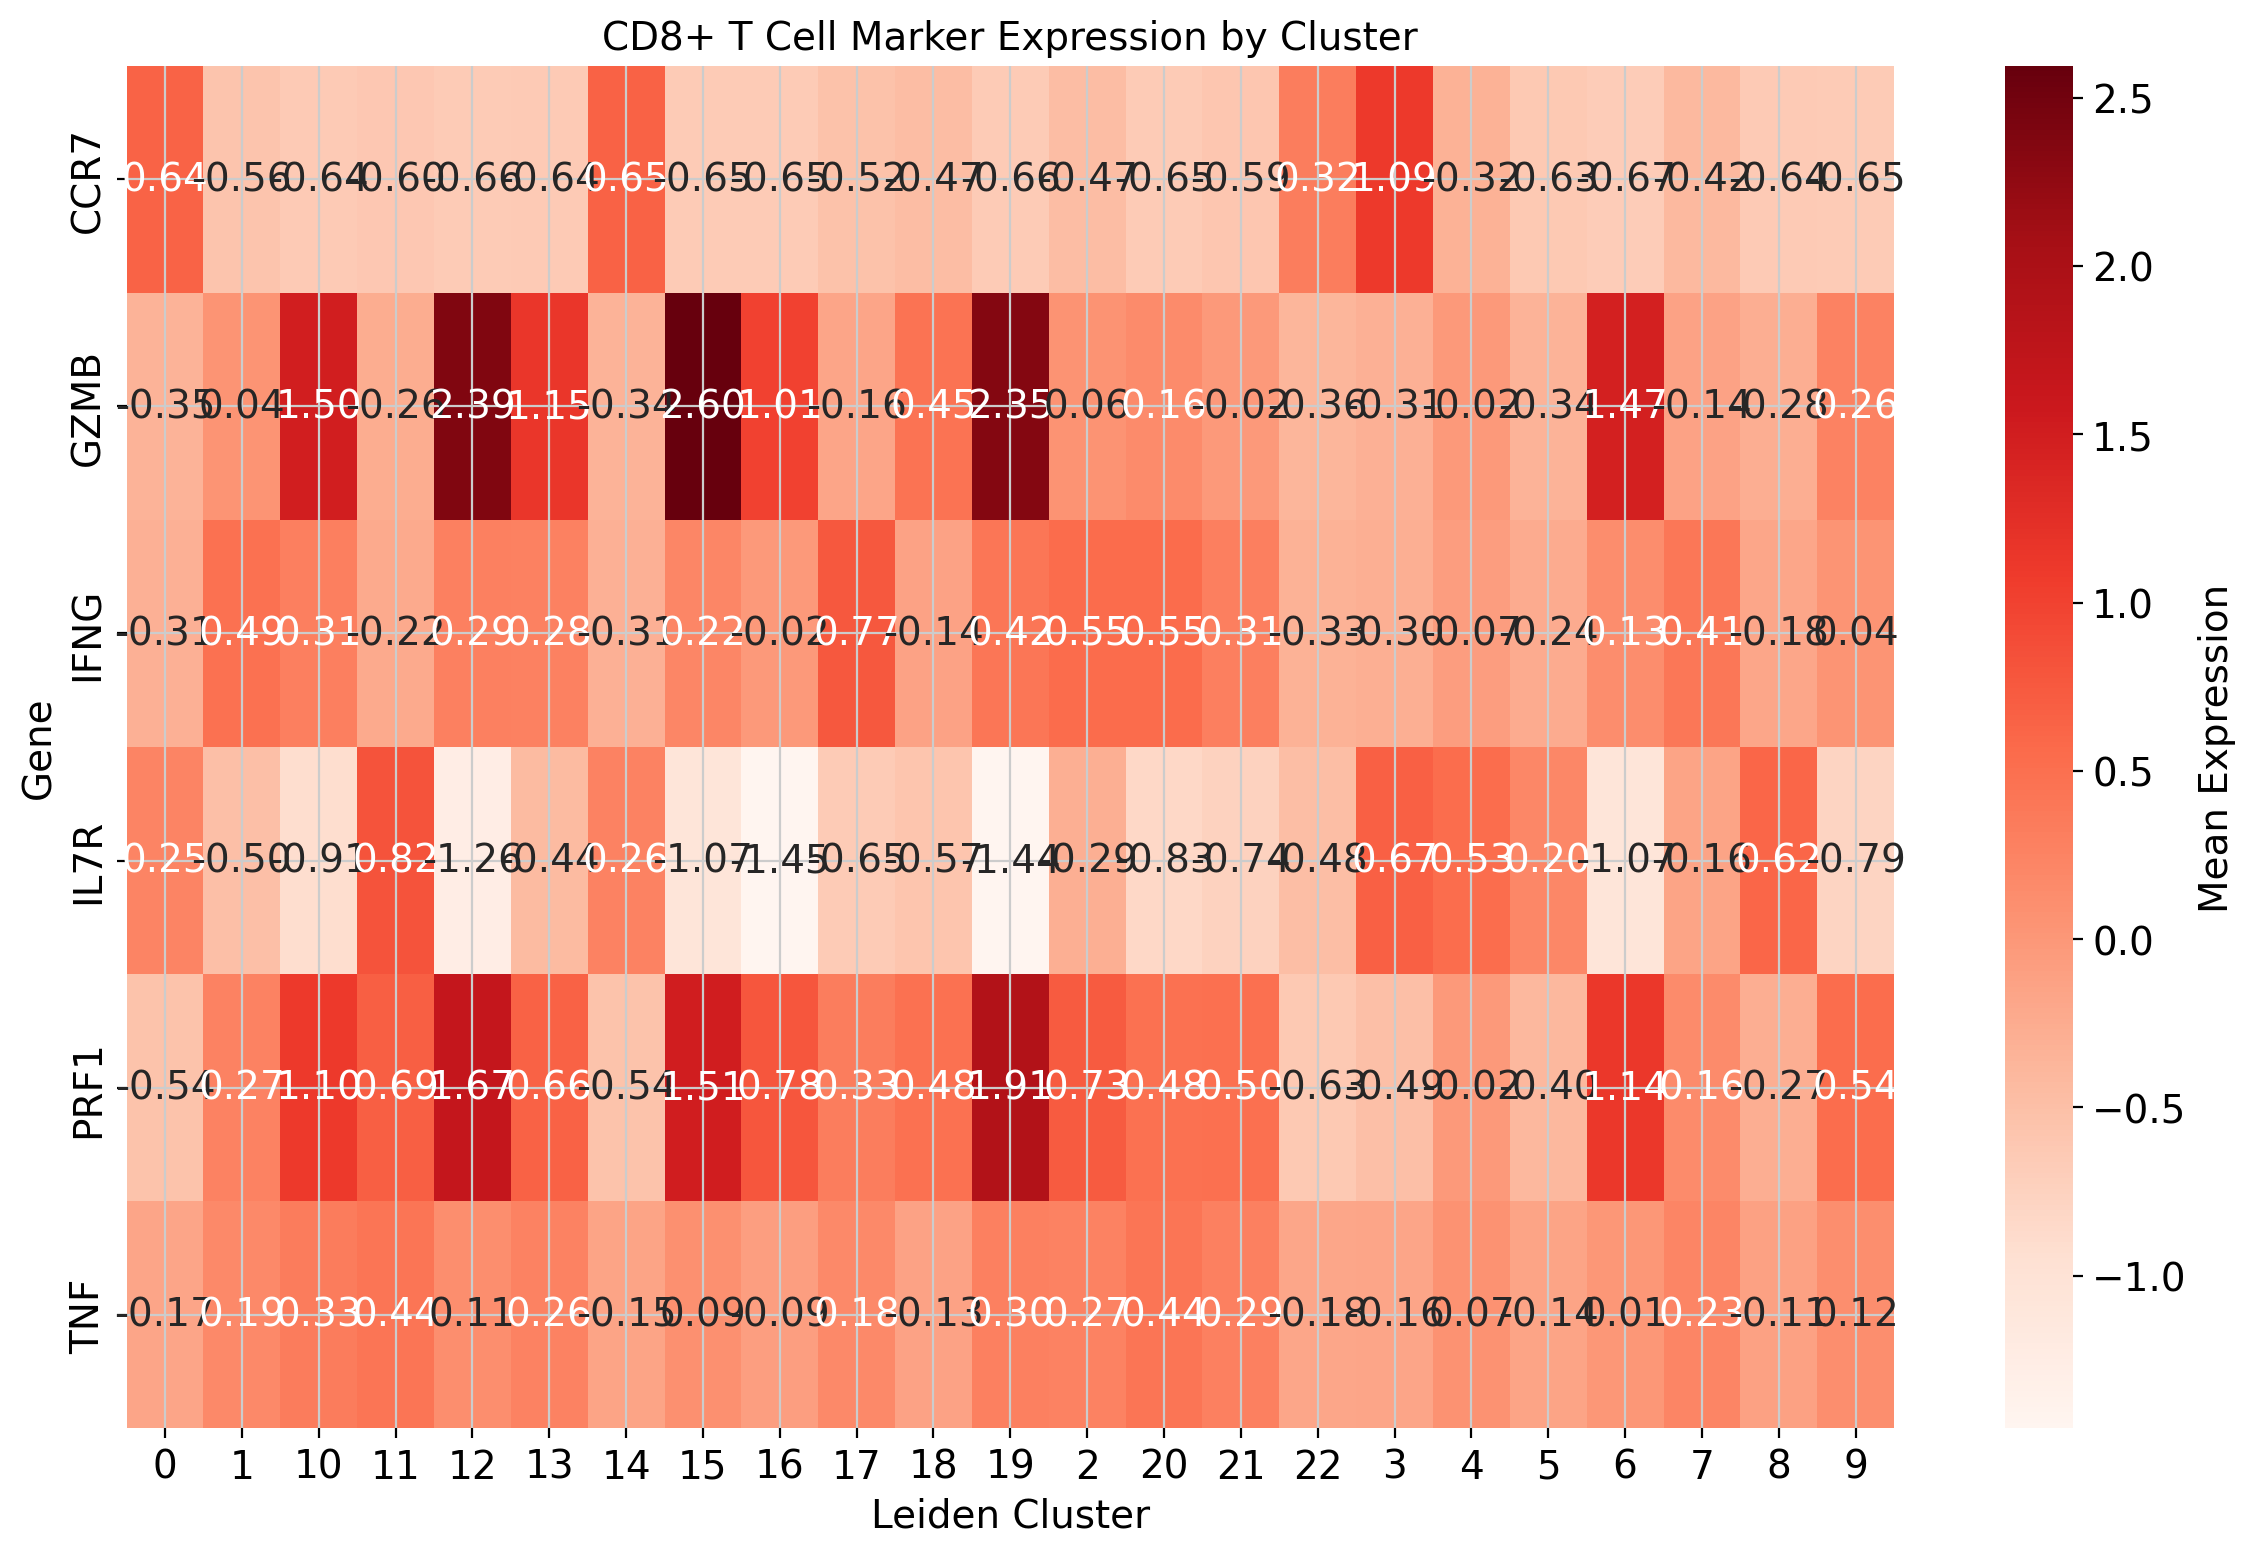

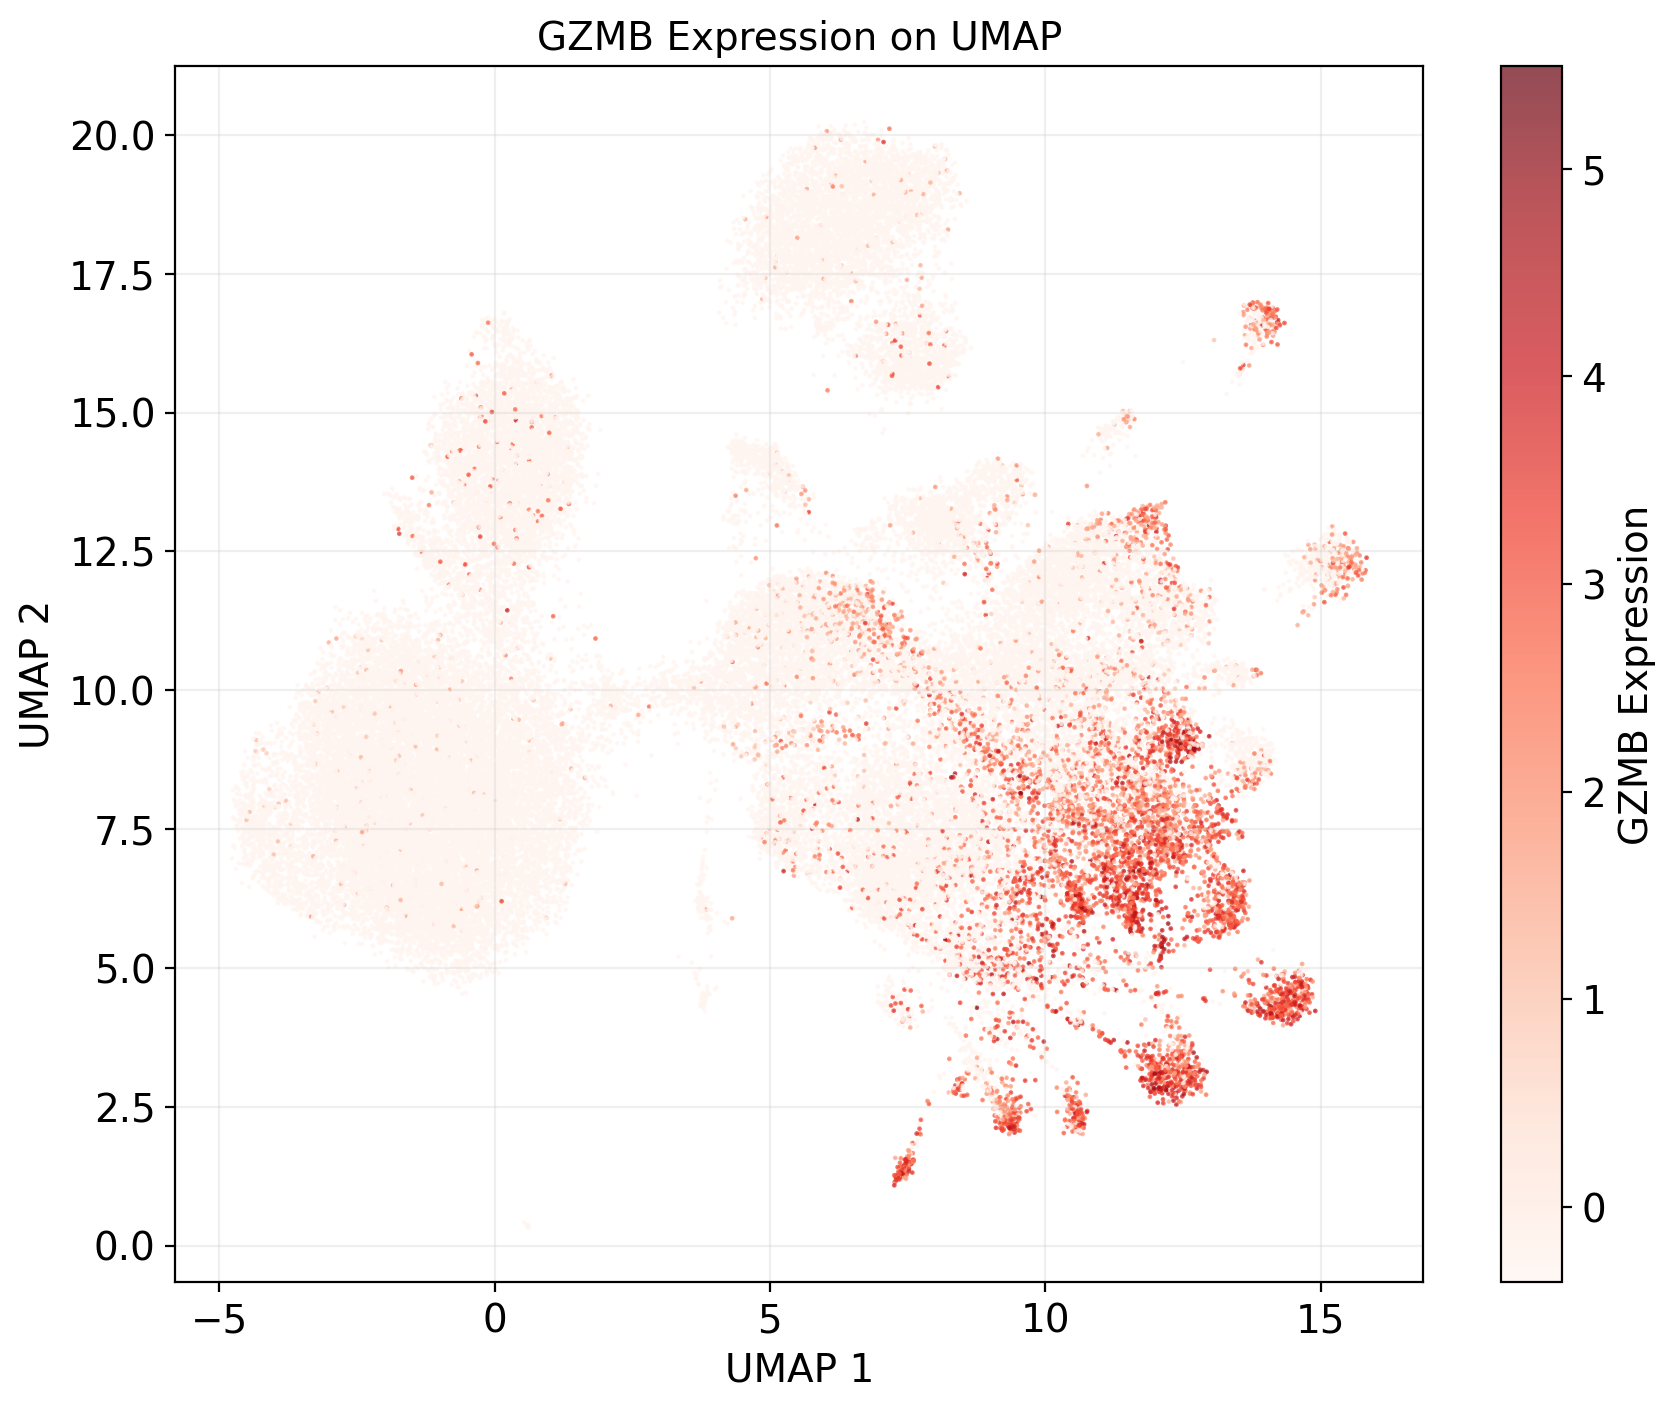

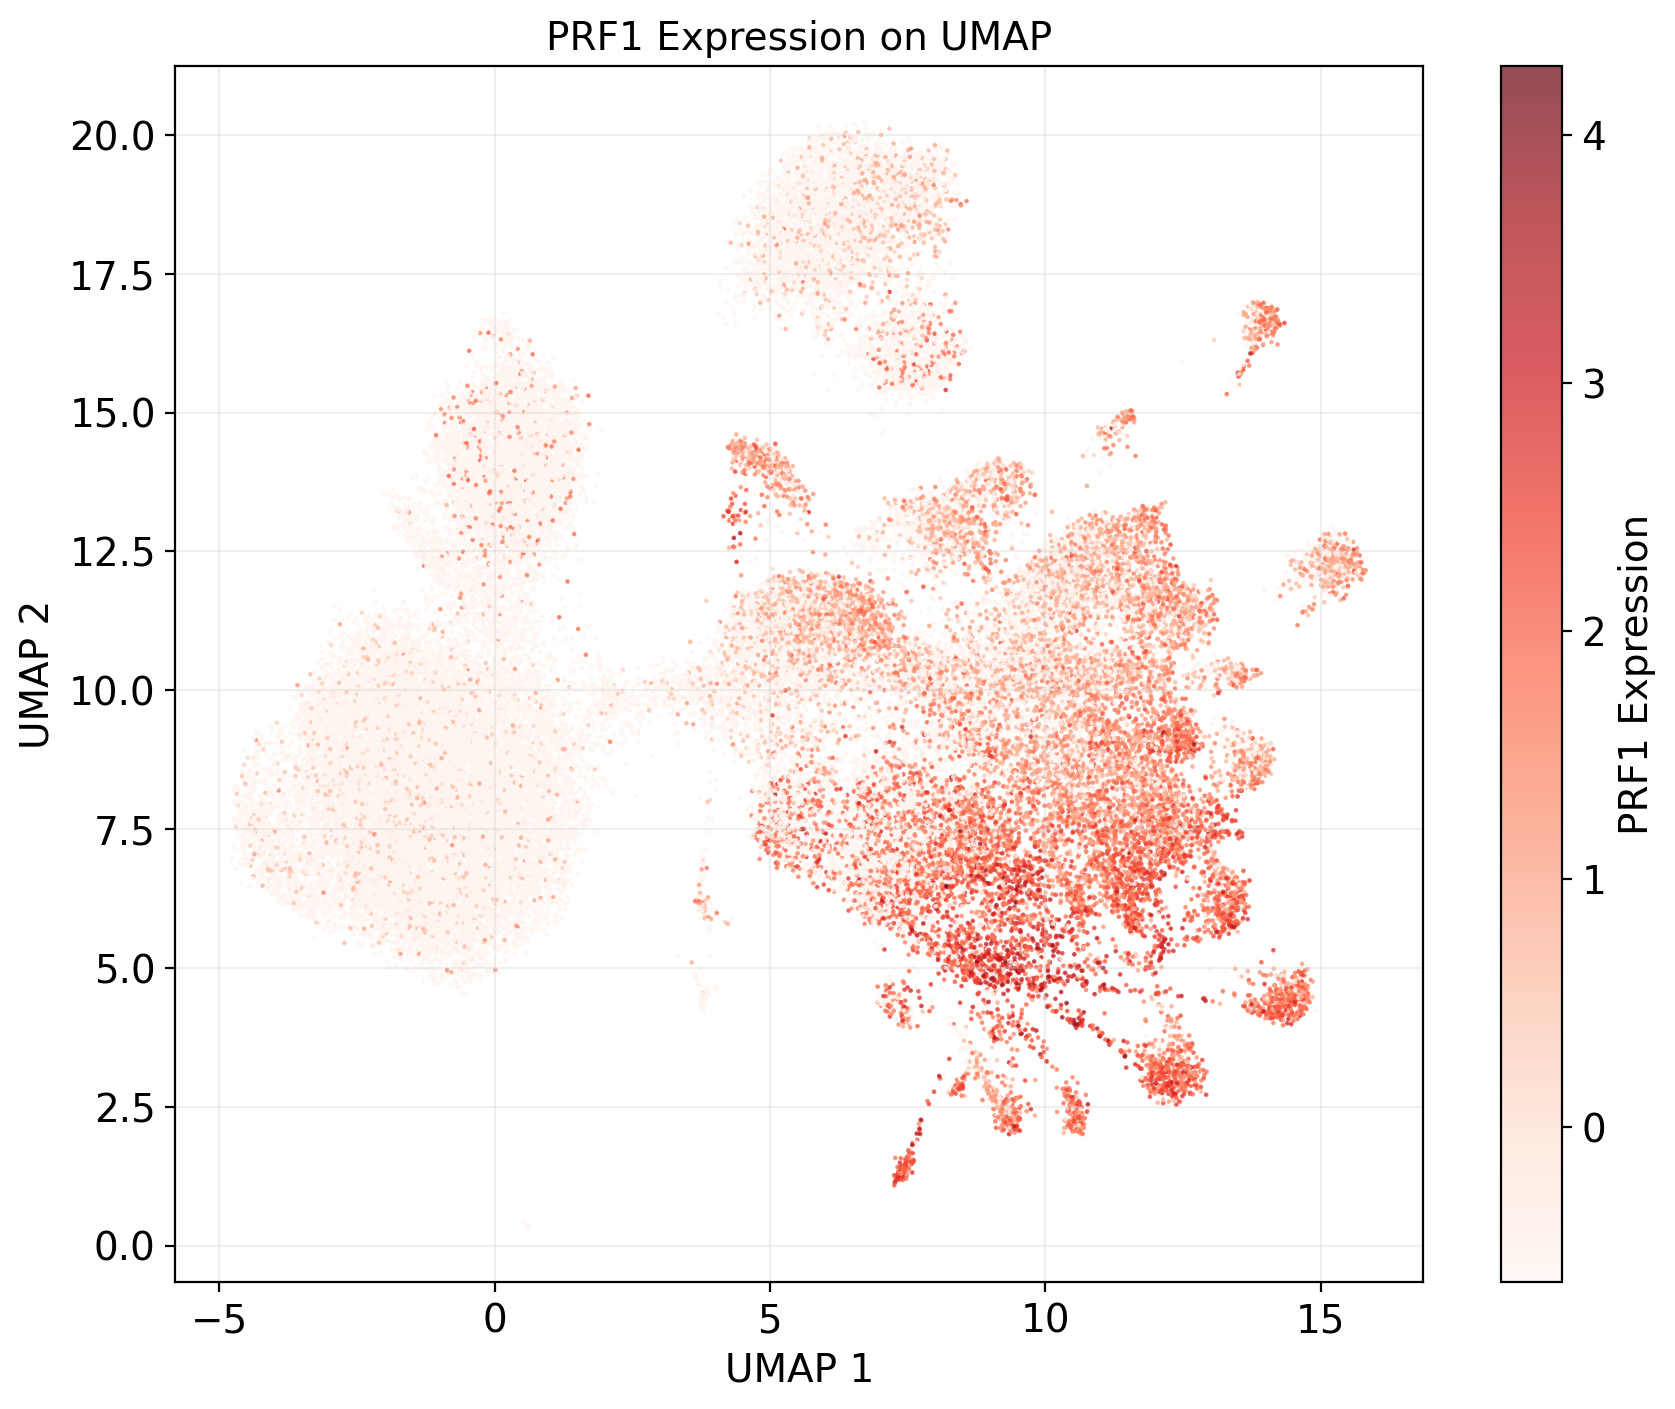

In [30]:
# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata_clustered, 'leiden', method='wilcoxon')

# CD8+ T cell markers to check
cd8_marker_genes = ['CD8A', 'CD8B', 'CD3D', 'CD3E', 'GZMB', 'PRF1', 'IFNG', 'TNF', 'CCR7', 'IL7R']
available_marker_genes = [gene for gene in cd8_marker_genes if gene in adata_clustered.var_names]

print(f"Available CD8+ T cell markers: {available_marker_genes}")

if len(available_marker_genes) > 0:
    # Create expression heatmap
    marker_expression_data = []

    for gene_name in available_marker_genes:
        gene_expression = adata_clustered[:, gene_name].X.toarray().flatten()
        for cell_idx, cluster_marker in enumerate(adata_clustered.obs['leiden']):
            marker_expression_data.append({
                'gene': gene_name,
                'cluster': cluster_marker,
                'expression': gene_expression[cell_idx]
            })

    marker_expr_df = pl.DataFrame(marker_expression_data)

    # Calculate mean expression per cluster
    cluster_mean_expr = (marker_expr_df
                        .group_by(['gene', 'cluster'])
                        .agg(pl.col('expression').mean().alias('mean_expression'))
                        .sort(['gene', 'cluster']))

    # Create heatmap
    heatmap_pivot_data = cluster_mean_expr.to_pandas().pivot(index='gene', columns='cluster', values='mean_expression')

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot_data, annot=True, cmap='Reds', fmt='.2f',
                cbar_kws={'label': 'Mean Expression'})
    plt.title('CD8+ T Cell Marker Expression by Cluster')
    plt.xlabel('Leiden Cluster')
    plt.ylabel('Gene')
    plt.tight_layout()
    plt.show()

    # Expression on UMAP for key markers
    if 'CD8A' in available_marker_genes:
        cd8a_expression = adata_clustered[:, 'CD8A'].X.toarray().flatten()

        plt.figure(figsize=(10, 8))
        cd8a_scatter = plt.scatter(umap_coordinates[:, 0], umap_coordinates[:, 1],
                                  c=cd8a_expression, s=0.5, alpha=0.7, cmap='Reds')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.title('CD8A Expression on UMAP')
        plt.colorbar(cd8a_scatter, label='CD8A Expression')
        plt.grid(True, alpha=0.3)
        plt.show()

    if 'GZMB' in available_marker_genes:
        gzmb_expression = adata_clustered[:, 'GZMB'].X.toarray().flatten()

        plt.figure(figsize=(10, 8))
        gzmb_scatter = plt.scatter(umap_coordinates[:, 0], umap_coordinates[:, 1],
                                  c=gzmb_expression, s=0.5, alpha=0.7, cmap='Reds')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.title('GZMB Expression on UMAP')
        plt.colorbar(gzmb_scatter, label='GZMB Expression')
        plt.grid(True, alpha=0.3)
        plt.show()

    if 'PRF1' in available_marker_genes:
        gzmb_expression = adata_clustered[:, 'PRF1'].X.toarray().flatten()

        plt.figure(figsize=(10, 8))
        gzmb_scatter = plt.scatter(umap_coordinates[:, 0], umap_coordinates[:, 1],
                                  c=gzmb_expression, s=0.5, alpha=0.7, cmap='Reds')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.title('PRF1 Expression on UMAP')
        plt.colorbar(gzmb_scatter, label='PRF1 Expression')
        plt.grid(True, alpha=0.3)
        plt.show()

else:
    print("No CD8+ markers found. Showing top marker genes per cluster:")
    # Show top marker genes using scanpy
    sc.pl.rank_genes_groups(adata_clustered, n_genes=5, sharey=False)

# **Analysis Summary**

In [ ]:
# Final summary
print(" ANALYSIS COMPLETE!")
print("=" * 50)
print(f" Original dataset: {adata_raw.shape}")
print(f" After QC filtering: {adata_filtered.shape}")
print(f" Highly variable genes: {adata_hvg.shape}")
print(f" Final clusters: {len(adata_clustered.obs['leiden'].cat.categories)}")
print(f" Cells analyzed: {adata_clustered.n_obs:,}")

print("\n Key Results:")
print(f"• Identified {len(adata_clustered.obs['leiden'].cat.categories)} distinct cell populations")
print(f"• Average UMI counts per cell: {adata_clustered.obs['total_counts'].mean():.0f}")
print(f"• Average genes per cell: {adata_clustered.obs['n_genes_by_counts'].mean():.0f}")
print(f"• Mitochondrial gene %: {adata_clustered.obs['pct_counts_mt'].mean():.1f}%")

if len(available_marker_genes) > 0:
    print(f"• CD8+ T cell markers detected: {len(available_marker_genes)}")
    print(f"• Available markers: {', '.join(available_marker_genes)}")

print("\n Modern Tools Used:")
print("• Polars: Ultra-fast data manipulation")
print("• Matplotlib: Publication-quality plots")
print("• Scanpy: Single-cell analysis pipeline")

# Save final results
final_results = {
    'n_cells_original': adata_raw.n_obs,
    'n_genes_original': adata_raw.n_vars,
    'n_cells_final': adata_clustered.n_obs,
    'n_genes_final': adata_clustered.n_vars,
    'n_clusters': len(adata_clustered.obs['leiden'].cat.categories),
    'mean_umi_counts': float(adata_clustered.obs['total_counts'].mean()),
    'mean_genes_per_cell': float(adata_clustered.obs['n_genes_by_counts'].mean()),
    'mean_mt_percent': float(adata_clustered.obs['pct_counts_mt'].mean())
}

print(f"\n Analysis summary: {final_results}")

 ANALYSIS COMPLETE!
 Original dataset: (55206, 33538)
 After QC filtering: (49661, 18860)
  Highly variable genes: (49661, 3000)
 Final clusters: 23
 Cells analyzed: 49,661

 Key Results:
• Identified 23 distinct cell populations
• Average UMI counts per cell: 4104
• Average genes per cell: 1388
• Mitochondrial gene %: 8.6%
• CD8+ T cell markers detected: 6
• Available markers: GZMB, PRF1, IFNG, TNF, CCR7, IL7R

 Modern Tools Used:
• Polars: Ultra-fast data manipulation
• Matplotlib: Publication-quality plots
• Scanpy: Single-cell analysis pipeline

 Analysis summary: {'n_cells_original': 55206, 'n_genes_original': 33538, 'n_cells_final': 49661, 'n_genes_final': 3000, 'n_clusters': 23, 'mean_umi_counts': 4103.75146484375, 'mean_genes_per_cell': 1388.1246853667867, 'mean_mt_percent': 8.578370094299316}
